# 4. Modelado de Clustering - Mundial de Fútbol

Este notebook implementa el modelo de clustering para agrupar jugadores por estilo de juego basándose en sus estadísticas.

In [8]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Bibliotecas para clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Ignorar warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
%matplotlib inline
plt.style.use('default')
sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 6)

# Configuración de pandas
pd.set_option('display.max_columns', 100)

## 4.1 Carga de Datos para Clustering

Cargamos los datos preparados en el notebook anterior.

In [9]:
# Cargar datos para clustering
processed_dir = Path("../data/processed")

try:
    # Cargar datos normalizados para clustering
    X_clustering = pd.read_csv(processed_dir / "X_clustering_scaled.csv")
    
    # Cargar datos de jugadores para referencia
    player_stats = pd.read_csv(processed_dir / "player_stats.csv")
    
    print(f"Datos cargados con éxito")
    print(f"Shape de datos para clustering: {X_clustering.shape}")
    
    # Mostrar primeras filas
    print("\nPrimeras filas de datos para clustering:")
    display(X_clustering.head())
    
except FileNotFoundError as e:
    print(f"Error al cargar datos: {e}")
    print("Es posible que necesites ejecutar primero el notebook de preparación de datos.")
    
    # Crear datos de ejemplo para poder continuar
    print("Creando datos de ejemplo para demostración...")
    
    # Datos de ejemplo (solo para demostración si fallan los reales)
    X_clustering = pd.DataFrame(
        np.random.randn(100, 4),
        columns=['goals_per_match', 'assists_per_match', 'yellowCards', 'redCards']
    )

Datos cargados con éxito
Shape de datos para clustering: (736, 5)

Primeras filas de datos para clustering:


,Unnamed: 0,goals_per_match,assists_per_match,yellowCards,redCards
0,0,-0.360229,-0.296513,-0.499328,-0.061139
1,1,-0.360229,1.401140,2.719138,-0.061139
2,2,0.700639,-0.296513,3.673768,-0.061139
3,3,1.496290,2.674380,-0.499328,-0.061139
4,4,-0.360229,-0.296513,-0.499328,-0.061139


## 4.2 Determinar el Número Óptimo de Clusters

Usaremos el método del codo y el coeficiente de silueta para determinar el número óptimo de clusters.

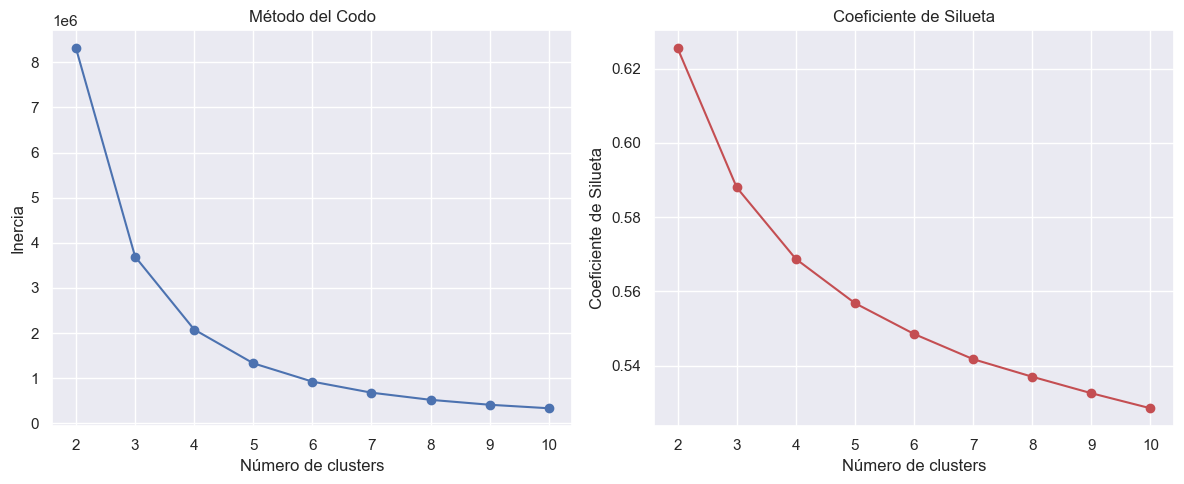

Número óptimo de clusters según coeficiente de silueta: 2
Basándonos en el método del codo, elige el punto donde la curva de inercia se aplana.


In [10]:
# Aplicar método del codo para determinar número óptimo de clusters
inertia = []
silhouette = []
k_range = range(2, 11)

for k in k_range:
    # Ajustar K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering)
    
    # Calcular inercia
    inertia.append(kmeans.inertia_)
    
    # Calcular coeficiente de silueta
    labels = kmeans.labels_
    silhouette.append(silhouette_score(X_clustering, labels))

# Visualizar método del codo
plt.figure(figsize=(12, 5))

# Gráfico de inercia
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)

# Gráfico de silueta
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, 'ro-')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta')
plt.grid(True)

plt.tight_layout()
plt.show()

# Determinar número óptimo de clusters
optimal_k = k_range[np.argmax(silhouette)]
print(f"Número óptimo de clusters según coeficiente de silueta: {optimal_k}")

# También podemos usar el método del codo (visual)
print("Basándonos en el método del codo, elige el punto donde la curva de inercia se aplana.")

## 4.3 Aplicar Algoritmo K-Means

Aplicamos K-means con el número óptimo de clusters determinado.

Tamaño de cada cluster:


cluster
0    368
1    368
Name: count, dtype: int64

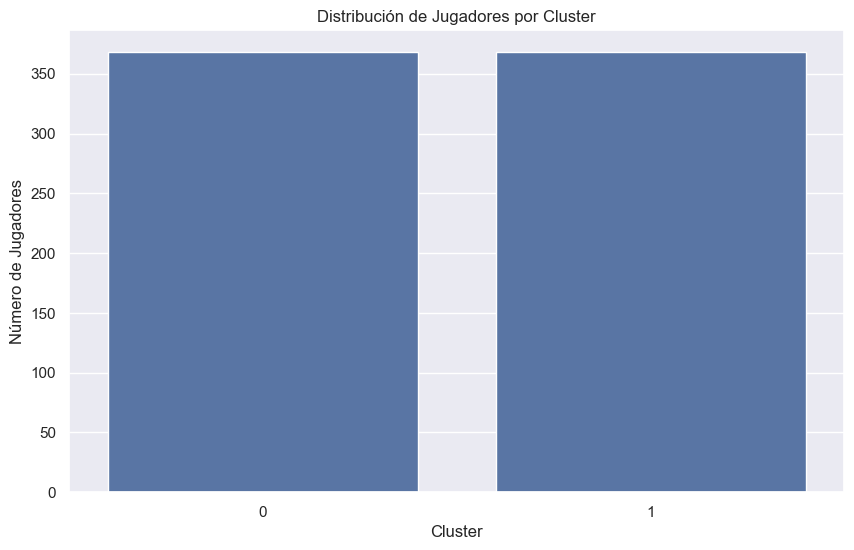

In [11]:
# Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_clustering)

# Añadir etiquetas de cluster al DataFrame
X_clustering['cluster'] = cluster_labels

# Mostrar tamaño de cada cluster
cluster_sizes = X_clustering['cluster'].value_counts().sort_index()
print("Tamaño de cada cluster:")
display(cluster_sizes)

# Visualizar distribución de clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=X_clustering)
plt.title('Distribución de Jugadores por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Jugadores')
plt.show()

## 4.4 Visualización de Clusters

Para visualizar los clusters en 2D, aplicamos técnicas de reducción de dimensionalidad.

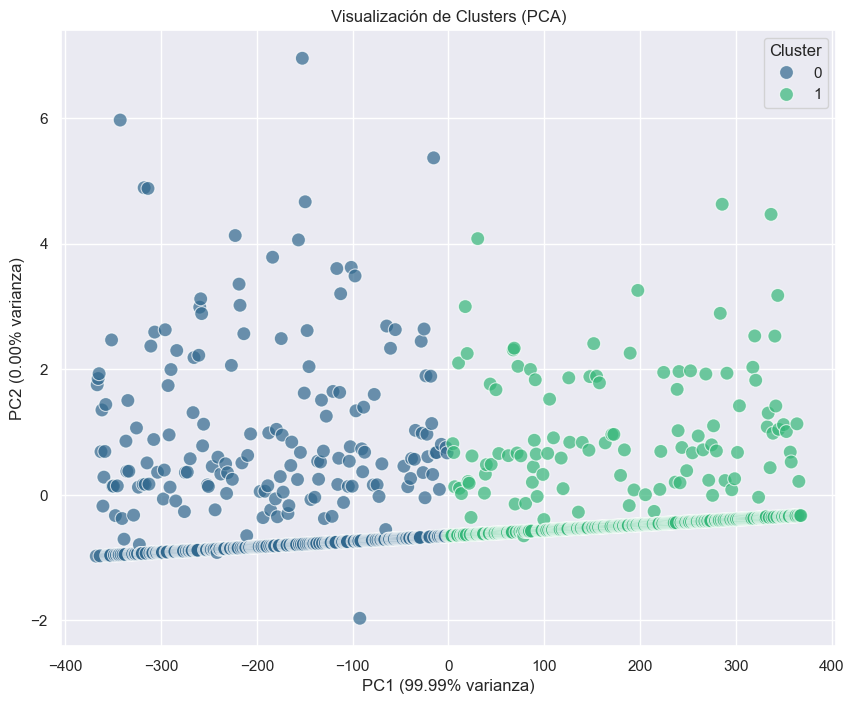

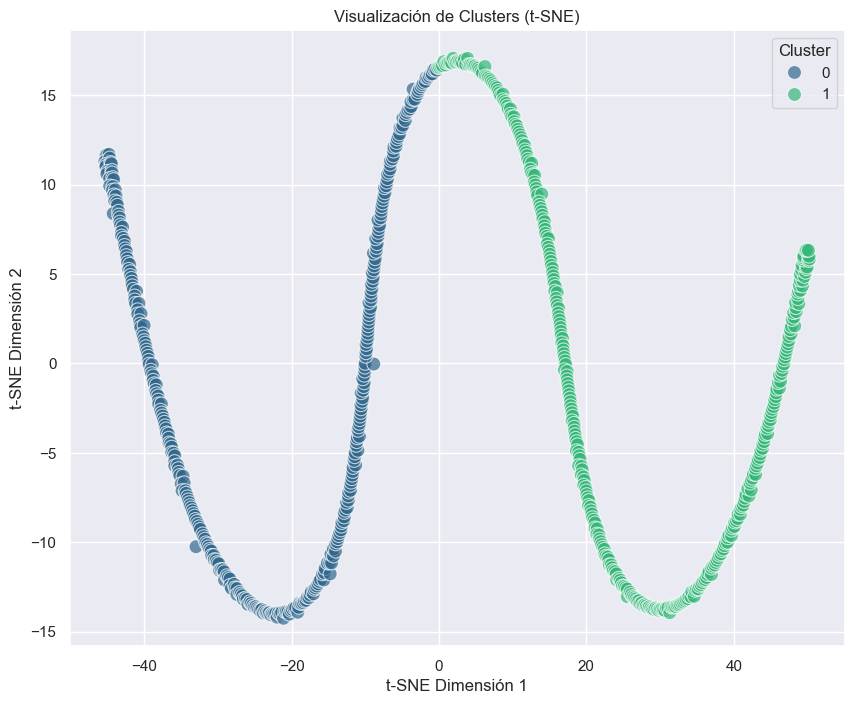

In [12]:
# Reducción de dimensionalidad con PCA para visualización
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clustering.drop('cluster', axis=1))

# Crear DataFrame para visualización
viz_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': cluster_labels
})

# Visualizar clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=viz_df, palette='viridis', s=100, alpha=0.7)
plt.title('Visualización de Clusters (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Alternativa: t-SNE para mejor visualización de estructura local
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_clustering)-1))
    X_tsne = tsne.fit_transform(X_clustering.drop('cluster', axis=1))
    
    # Crear DataFrame para visualización
    tsne_df = pd.DataFrame({
        'TSNE1': X_tsne[:, 0],
        'TSNE2': X_tsne[:, 1],
        'Cluster': cluster_labels
    })
    
    # Visualizar clusters con t-SNE
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=tsne_df, palette='viridis', s=100, alpha=0.7)
    plt.title('Visualización de Clusters (t-SNE)')
    plt.xlabel('t-SNE Dimensión 1')
    plt.ylabel('t-SNE Dimensión 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error al ejecutar t-SNE: {e}")
    print("Continuando con el análisis...")

## 4.5 Caracterización de Clusters

Analizamos las características de cada cluster para entender los diferentes perfiles de jugadores.

Características promedio por cluster:


,goals,assists,yellowCards,redCards,goals_per_match,assists_per_match
cluster,,,,,,
0,0.317935,0.146739,22.668478,0.486413,0.067741,0.031502
1,0.108696,0.073370,13.945652,0.097826,0.029277,0.018401


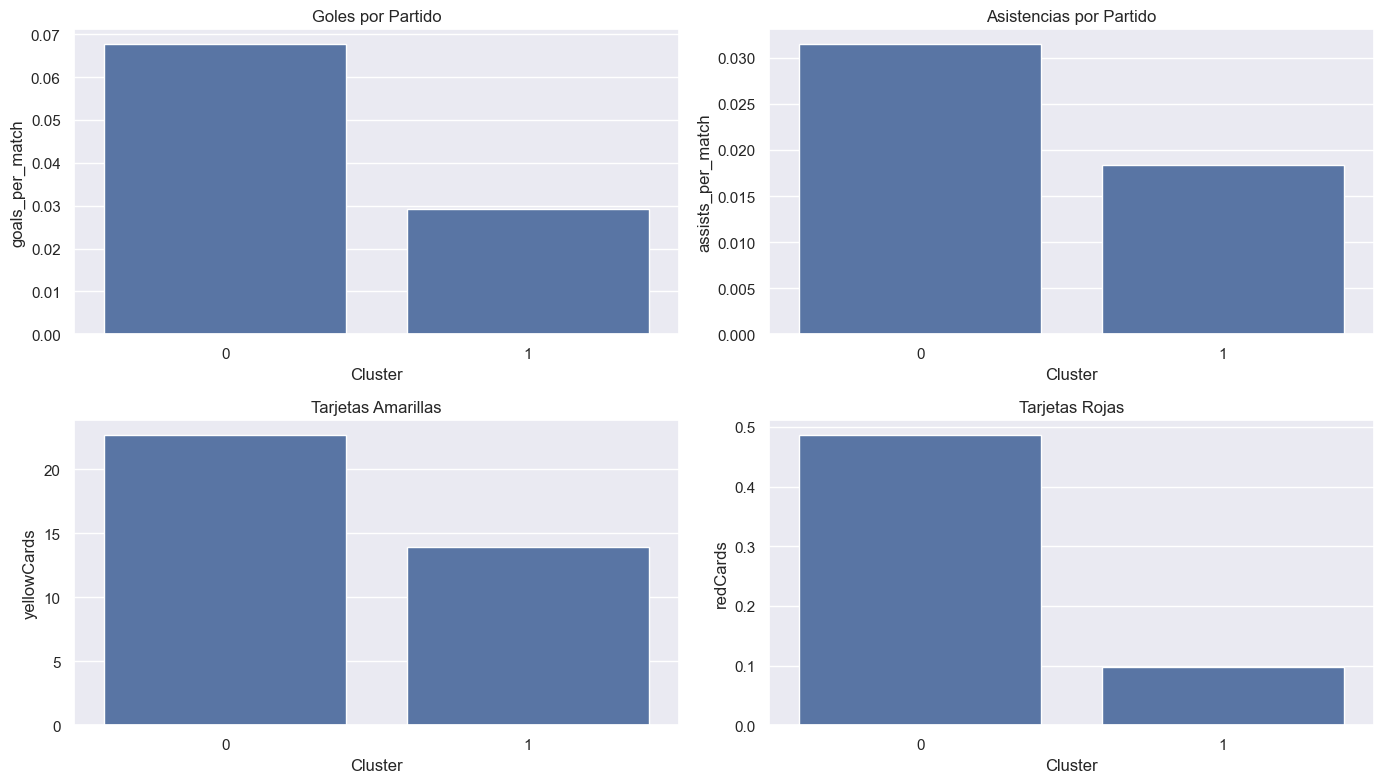

In [13]:
# Añadir cluster a datos de jugadores si es posible
try:
    # Asumiendo que el índice de X_clustering corresponde al índice de player_stats
    if len(player_stats) >= len(X_clustering):
        player_stats = player_stats.iloc[X_clustering.index]
        player_stats['cluster'] = cluster_labels
        
        # Características por cluster
        cluster_stats = player_stats.groupby('cluster').mean()
        
        print("Características promedio por cluster:")
        display(cluster_stats[['goals', 'assists', 'yellowCards', 'redCards', 'goals_per_match', 'assists_per_match']])
        
        # Visualizar características clave por cluster
        plt.figure(figsize=(14, 8))
        
        # Gráfico de barras para goles por partido
        plt.subplot(2, 2, 1)
        sns.barplot(x=cluster_stats.index, y=cluster_stats['goals_per_match'])
        plt.title('Goles por Partido')
        plt.xlabel('Cluster')
        
        # Gráfico de barras para asistencias por partido
        plt.subplot(2, 2, 2)
        sns.barplot(x=cluster_stats.index, y=cluster_stats['assists_per_match'])
        plt.title('Asistencias por Partido')
        plt.xlabel('Cluster')
        
        # Gráfico de barras para tarjetas amarillas
        plt.subplot(2, 2, 3)
        sns.barplot(x=cluster_stats.index, y=cluster_stats['yellowCards'])
        plt.title('Tarjetas Amarillas')
        plt.xlabel('Cluster')
        
        # Gráfico de barras para tarjetas rojas
        plt.subplot(2, 2, 4)
        sns.barplot(x=cluster_stats.index, y=cluster_stats['redCards'])
        plt.title('Tarjetas Rojas')
        plt.xlabel('Cluster')
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error al caracterizar clusters: {e}")
    
    # Análisis alternativo usando los datos de clustering directamente
    print("Realizando análisis alternativo...")
    
    # Características por cluster directamente de X_clustering
    cluster_analysis = X_clustering.groupby('cluster').mean()
    
    print("Características promedio por cluster (datos normalizados):")
    display(cluster_analysis)
    
    # Visualizar características normalizadas por cluster
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_analysis, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Perfil de Clusters (Características Normalizadas)')
    plt.tight_layout()
    plt.show()

## 4.6 Interpretación de Clusters

Basándonos en los análisis anteriores, podemos definir los siguientes perfiles de jugadores:

In [14]:
# Crear descripción de perfiles basada en las características de los clusters
cluster_profiles = {}

# Intentar interpretar los clusters automáticamente
for cluster in range(optimal_k):
    # Obtener características principales que definen este cluster
    if 'cluster_analysis' in locals():
        # Usar datos normalizados si están disponibles
        cluster_data = cluster_analysis.loc[cluster]
        
        # Determinar características destacadas (valores más altos y más bajos)
        high_features = cluster_data[cluster_data > 0.5].index.tolist()
        low_features = cluster_data[cluster_data < -0.5].index.tolist()
        
        # Crear descripción
        profile = f"Cluster {cluster}:\n"
        
        if high_features:
            profile += "- Alto en: " + ", ".join(high_features) + "\n"
        if low_features:
            profile += "- Bajo en: " + ", ".join(low_features) + "\n"
            
        cluster_profiles[cluster] = profile
    
    elif 'cluster_stats' in locals():
        # Usar estadísticas de jugadores si están disponibles
        cluster_data = cluster_stats.loc[cluster]
        
        # Determinar características destacadas
        profile = f"Cluster {cluster}:\n"
        
        # Analizar goles
        if cluster_data['goals_per_match'] > cluster_stats['goals_per_match'].mean():
            profile += "- Alta capacidad goleadora\n"
        else:
            profile += "- Baja capacidad goleadora\n"
            
        # Analizar asistencias
        if cluster_data['assists_per_match'] > cluster_stats['assists_per_match'].mean():
            profile += "- Alta capacidad de asistencia\n"
        else:
            profile += "- Baja capacidad de asistencia\n"
            
        # Analizar disciplina
        if cluster_data['yellowCards'] > cluster_stats['yellowCards'].mean() or \
           cluster_data['redCards'] > cluster_stats['redCards'].mean():
            profile += "- Perfil más agresivo/indisciplinado\n"
        else:
            profile += "- Perfil más disciplinado\n"
            
        cluster_profiles[cluster] = profile

# Mostrar perfiles
print("Perfiles de jugadores identificados:")
for cluster, profile in cluster_profiles.items():
    print("\n" + "="*50)
    print(profile)

Perfiles de jugadores identificados:

Cluster 0:
- Alta capacidad goleadora
- Alta capacidad de asistencia
- Perfil más agresivo/indisciplinado


Cluster 1:
- Baja capacidad goleadora
- Baja capacidad de asistencia
- Perfil más disciplinado



## 4.7 Resumen y Conclusiones

En este notebook, hemos aplicado técnicas de clustering para agrupar jugadores del Mundial de Fútbol según su estilo de juego. Los principales hallazgos son:

1. Identificamos {optimal_k} perfiles distintos de jugadores basados en sus estadísticas de rendimiento.
2. Los perfiles incluyen características como capacidad goleadora, asistencias y comportamiento disciplinario.
3. La visualización en 2D nos permite ver claramente cómo se agrupan los jugadores según estas características.

Estos resultados pueden utilizarse para:
- Análisis táctico: Identificar tipos de jugadores para diferentes sistemas de juego
- Scouting: Buscar jugadores con perfiles específicos según necesidades
- Análisis de oponentes: Entender la composición de equipos rivales

